# shRNA counts, Zexi Hu, I16D022a01

In [30]:
! date

Di 16. Aug 16:39:47 CEST 2016


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import json

#%load_ext rpy2.ipython
%matplotlib inline

In [32]:
cd "~/data/rnacount/"

/home/adr/data/rnacount


In [34]:
sample = "I16D022a01"
fastq = "./20160810110515_I16D022a01_01_NoIndex_L001_R1_001.fastq.gz/20160810110515_I16D022a01_01_NoIndex_L001_R1_001.fastq"
libraries = ["KPP shRNA list.xlsx"]
barcodes = "./4nt barcode_1.xlsx"

for file in [fastq, barcodes] + libraries:
    ! sha256sum "{file}"

5afcef00440c39be77f5a7c370977635c3380130286076e83156e80768ebc60a  ./20160810110515_I16D022a01_01_NoIndex_L001_R1_001.fastq.gz/20160810110515_I16D022a01_01_NoIndex_L001_R1_001.fastq
7026688692b625f6047cad346a7a0e4369ce3093554ccd6547cfbe9145f9819f  ./4nt barcode_1.xlsx
bf343235b7f0c0694e386f15efa56a1a6cec34dee20b5f86ca0a71f1b4cdf62d  KPP shRNA list.xlsx


In [35]:
libs = []
for lib in libraries:
    if lib.endswith('.csv'):
        libs.append(pd.read_csv(lib, header=None, sep='\t', names=["seq"]))
    elif lib.endswith('.xlsx'):
        libs.append(pd.read_excel(lib, names=["guide", "seq"], index_col=0))
    else:
        raise ValueError("Unknown library format")

library = pd.concat(libs, axis=0, verify_integrity=True)
library = library['seq'].str.upper()
assert library.index.is_unique
library = library.drop_duplicates()
library = library.str[20:39]
assert library.value_counts().max() == 1
library = library.astype(bytes)

In [36]:
barcodes = pd.read_excel(barcodes, parse_cols=[1], names=['barcode'])['barcode']
barcodes = barcodes.str.upper().astype(bytes)
assert barcodes.value_counts().max() == 1

In [37]:
%run -n ~/git/rnacount/rnacount.py

In [38]:
reads = read_fastq(fastq)

In [39]:
%%time
counts, stats, oligo_counts = count_reads(
    reads,
    library=library,
    barcodes=barcodes,
    loop_rc=b"TACATCTGTGGCTTCACTA",
    #adapters=[b"ATCTCGTATGCCGTCTTCTGCTTG", b"TCGTATGCCGTCTTCTGCTTG"],
    adapters=[b"ATCTCGTA", b"TCGTATG"],
    oligo_offset=-20,
    barcode_offset=19,
    adapter_offsets=[23, 23],
    expect_loop_idx=20,
    oligo_len=19,
    barcode_len=4,
)

CPU times: user 9min 28s, sys: 9.88 s, total: 9min 38s
Wall time: 9min 38s


In [40]:
with open('stats_{}.json'.format(sample), 'w') as file:
    json.dump(stats, file)

In [41]:
counts.to_excel('counts_{}.xlsx'.format(sample))

counts.index.name = "gene"
counts.columns.name = "barcode"

counts_ = counts.unstack()
counts_.name = "count"

groups = counts_.reset_index().groupby("barcode")
by_barcode = dict(
    (
        key,
        val.sort_values(by=["count", "gene"], ascending=False)
                .reset_index()[["gene", "count"]]
    )
    for key, val in groups
)
counts_sorted = pd.concat(by_barcode, axis=1)
counts_sorted.to_excel("counts_sorted_{}.xlsx".format(sample))

## Quality control

In [42]:
stats['num_reads']

158750762

Number of reads with loop and adapter sequences but no valid barcode

In [43]:
stats['loop__adapter__no_barcode']

464473

In [44]:
100 * stats['loop__adapter__no_barcode'] / (stats['num_reads'] - stats['no_loop'] - stats['loop__no_adapter'])

0.3442792326922548

Percentage of reads that contain the loop sequence:

In [45]:
100 * (stats['num_reads'] - stats['no_loop']) / stats['num_reads']

85.92316615147963

What percentage of those reads does not contain the beginnig of the adapter sequence after the loop?

In [46]:
100 * stats['loop__no_adapter'] / (stats['num_reads'] - stats['no_loop'])

1.0937908633125524

What percentage of reads with loop and adapter contain one of the expected shRNA sequences from the library?

In [47]:
100 - 100 * stats['loop__adapter__barcode__no_oligo'] / (stats['num_reads'] - stats['no_loop'] - stats['loop__no_adapter'])

72.90732064696238

How may reads with loop, adapter and library shRNA do we get in total?

In [48]:
counts.sum().sum()

87923885

Percentage of all reads:

In [49]:
100 * counts.sum().sum() / stats['num_reads']

55.384858562127718

What are the most common sequences that occured instead of the library sequences?

In [50]:
oligo_counts.most_common(10)

[(b'', 3653758),
 (b'GGAATTATAATGCCTATCT', 195029),
 (b'TTCAAGTCAAATCACAGAA', 192846),
 (b'GGAATTATAATGCCCATCT', 146826),
 (b'TCCAGTTATTGTAAATGAT', 144485),
 (b'ACCAGGAATGTAGCTATGC', 142842),
 (b'ACCTTTGCAGACGTTCATT', 142554),
 (b'TCCCAAAGTACTTACTATT', 127365),
 (b'CTCCTAGAGACAATATGCA', 101177),
 (b'CCATAGTTCCTGCCTGGAT', 81307)]

At which positions did we find the loop sequence (0-based)? (We want them to start at position 22)

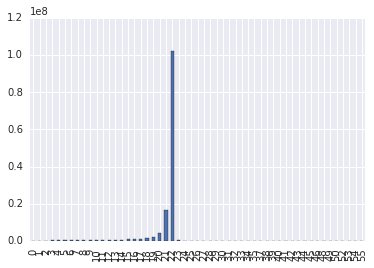

In [51]:
pd.Series(stats['loop_pos_dist']).plot.bar()

Same plot, but on a log scale:

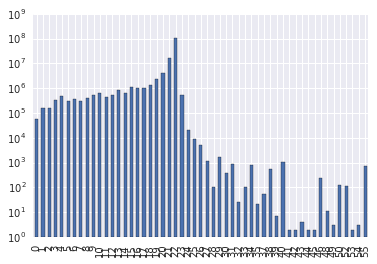

In [52]:
pd.Series(stats['loop_pos_dist']).plot.bar(log=True)

How many of those reads contained which barcode?
(second plot again on log scale)

In [53]:
counts.sum(axis=0)

barcode
0      8881049
1      9680208
2     10833715
3      9483055
4     11126135
5     11357760
6      6854521
7      9817739
8      9854486
9         1510
10        1413
11         361
12         436
13       29817
14         761
15         542
16         236
17         141
dtype: int64

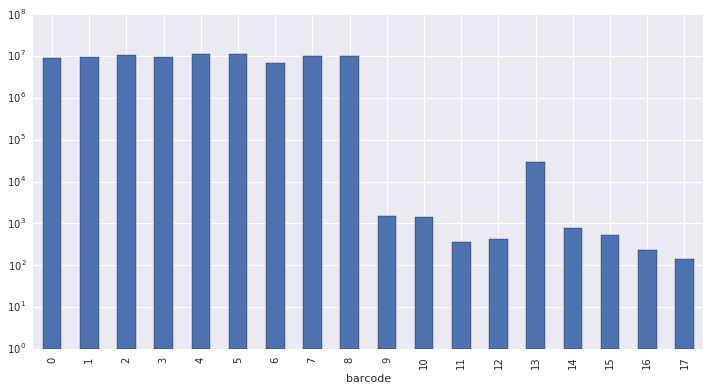

In [54]:
counts.sum(axis=0).plot.bar(log=True, figsize=(12, 6))

In [55]:
df = counts.T.iloc[:9].T

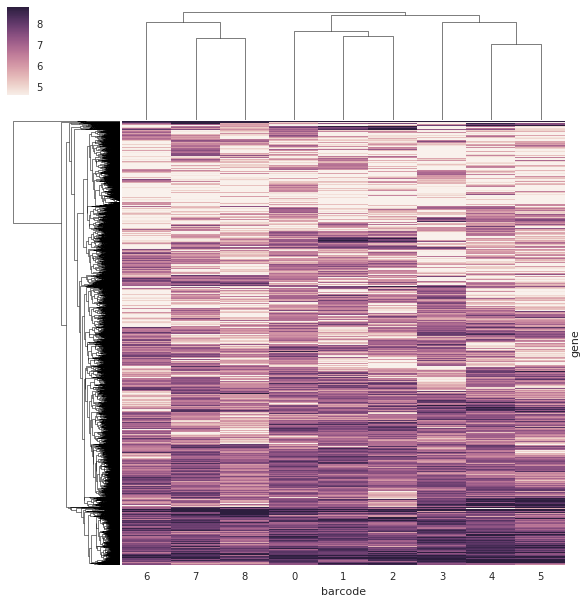

In [56]:
sb.clustermap(np.log(df + 100), yticklabels=[], robust=True)